# Automotive Appraiser using Machine Learning

This project will try to appraise the value of a given vehicle based on its make, model, year, mileage and other attributes.

A live, interractive demonstration can be found at www.auto-appraiser.loudpumpkins.com

## Collection

Live data is collected from a Canadian, classified ads website: www.kijiji.ca. We use https://github.com/loudpumpkins/selenium2, a selenium (python) based repository, to puppeteer a browser to collect ~10,000 records.

In [ ]:
import csv
import os
# from selenium.common.exceptions import (NoSuchElementException,
#                                         ElementNotInteractableException)

# from selenium2 import Browser


def links_generator():
	"""
	Navigate through www.kijiji.ca to find as many ads for Hondas as possible in
	Ontario. Yields one unique link at a time.
	"""
	processed_links = set()
	driver = Browser('ff')
	driver.goto('https://www.kijiji.ca/b-cars-trucks/ontario/honda-new__used/c174l9004a54a49')

	while True:
		links = driver.find_elements('//a[@class="title "]')
		for link in links:
			if link.get_attribute('href') not in processed_links:
				processed_links.add(link.get_attribute('href'))
				yield link.get_attribute('href')

		try:
			# go to the next page for more links
			driver.find_element('//a[@title="Next"]').click()
		except NoSuchElementException:
			break


def get_processed_links(filename, csv_fieldnames):
	"""
	Go through the 'raw_data.csv' file to find all the links that have already
	been processed.
	"""
	with open(filename, mode='r', newline='') as csv_fd:
		reader = csv.DictReader(csv_fd, fieldnames=csv_fieldnames)
		return {row['link'] for row in reader}


if __name__ == '__dont_run__':
	"""
	Go to 'kijiji.ca', a Canadian classified ads website, to fetch live ads of 
	vehicles for sell in Ontario.
	"""
	csv_fieldnames = ['link', 'price', 'make', 'model', 'year', 'kilometres',
	                  'body_type', 'drivetrain', 'transmission', 'fuel_type',
	                  'trim', 'colour', 'description']

	raw_data_filename = 'raw_data.csv'
	if not os.path.exists(raw_data_filename):
		with open(raw_data_filename, 'w'):
			pass

	browser = Browser('ff')
	processed_links = get_processed_links(raw_data_filename, csv_fieldnames)
	for link in links_generator():
		if link in processed_links:
			continue
		processed_links.add(link)
		browser.goto(link)
		row = dict()
		row['link'] = link
		try:
			more_btn = browser.find_element(
				"//button[starts-with(@class, 'showMoreButton')]")
			browser.driver.execute_script("arguments[0].scrollIntoView(false);",
			                              more_btn)
			more_btn.click()
		except (ElementNotInteractableException, NoSuchElementException):
			pass

		fields = {
			'price': '//span[@itemprop="price"]',  # '$38,940.00'
			'body_type': '//dd[@itemprop="bodyType"]/a',  # 'Sedan'
			'drivetrain': '//dd[@itemprop="driveWheelConfiguration"]',  # 'Front-wheel drive (FWD)'
			'transmission': '//dd[@itemprop="vehicleTransmission"]',  # 'Automatic'
			'fuel_type': '//dd[@itemprop="fuelType"]',  # 'Other'
			'kilometres': '//dd[@itemprop="mileageFromOdometer"]',  # '151,543'
			'year': '//dd[@itemprop="vehicleModelDate"]/a',  # '2013'
			'make': '//dd[@itemprop="brand"]/a',  # 'Honda'
			'model': '//dd[@itemprop="model"]/a',  # 'Civic'
			'trim': '//dd[@itemprop="vehicleConfiguration"]',  # Trim; 'El'
			'colour': '//dd[@itemprop="color"]',  # 'White'
			'description': '//div[@itemprop="description"]',  # ''
		}

		for key, value in fields.items():
			try:
				row[key] = browser.find_element(value).text
			except NoSuchElementException:
				row[key] = 'None'
			except UnicodeEncodeError:
				row[key] = 'Unicode Error'

		with open(raw_data_filename, mode='a', newline='') as csv_fd:
			try:
				writer = csv.DictWriter(csv_fd, fieldnames=csv_fieldnames)
				writer.writerow(row)
			except UnicodeEncodeError:
				print(row)

All raw data collected: www.auto-appraiser.loudpumpkins.com/data/raw

Sample of the raw data collected:
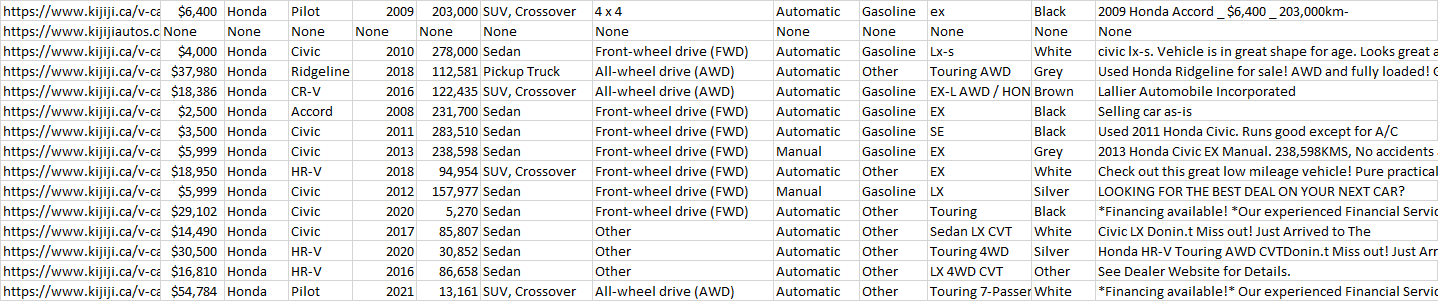

## Exploration

We will start by visualizing our data distribution and seeing which fields are the most useful ones and what we will need to do to massage our data into a machine learning model.

Our raw data contains the following fields:
**'link', 'price', 'make', 'model', 'year', 'kilometres', 'body_type', 'drivetrain', 'transmission', 'fuel_type', 'trim', 'colour', 'description'**

In [ ]:
# load raw data from webserver
import urllib.request, json
with urllib.request.urlopen("http://auto-appraiser.loudpumpkins.com/data/raw") as url:
  raw_data = json.loads(url.read().decode())

### price

Visual inspection of the data shows that some rows do not have a price but instead have text such as 'Please Contact' or 'Swap/Trade'. When prices are available, they all follow a pattern of `$xxx,xxx.xx` or `$xxx,xxx` where `x` is a digit. We will use regular expressions to confirm this assumption.

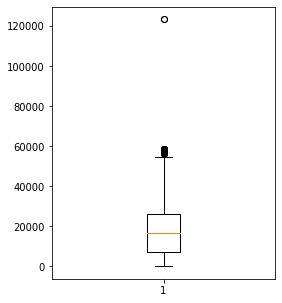

Rejected: {'None', 'Free', 'Swap/Trade', 'Please Contact'}


In [ ]:
import csv
import matplotlib.pyplot as plt
import re

if __name__ == '__main__':
	rejected = set()
	prices = []
	for row in raw_data:
		price = row['price']
		if re.search("^\$(\d{1,3},\d{3}|\d{1,3})(\.\d{2})?$", price):
			# Assumed pattern: $(xxx,)xxx.xx | $(xxx,)xxx
			prices.append(int(float(price.replace('$', '').replace(',', ''))))
		else:
			rejected.add(price)

	fig = plt.figure(figsize=(4, 5))
	plt.boxplot(prices)
	plt.show()
	print('Rejected:', rejected)

The price records that failed the assumed pattern are:

> {'Free', 'Swap/Trade', 'None', 'Please Contact'}

And finally, after plotting the valid prices in a box plot, we observe two issues:
1. Outliers at ~\$120 000
1. Some vehicles sold for ~\$0

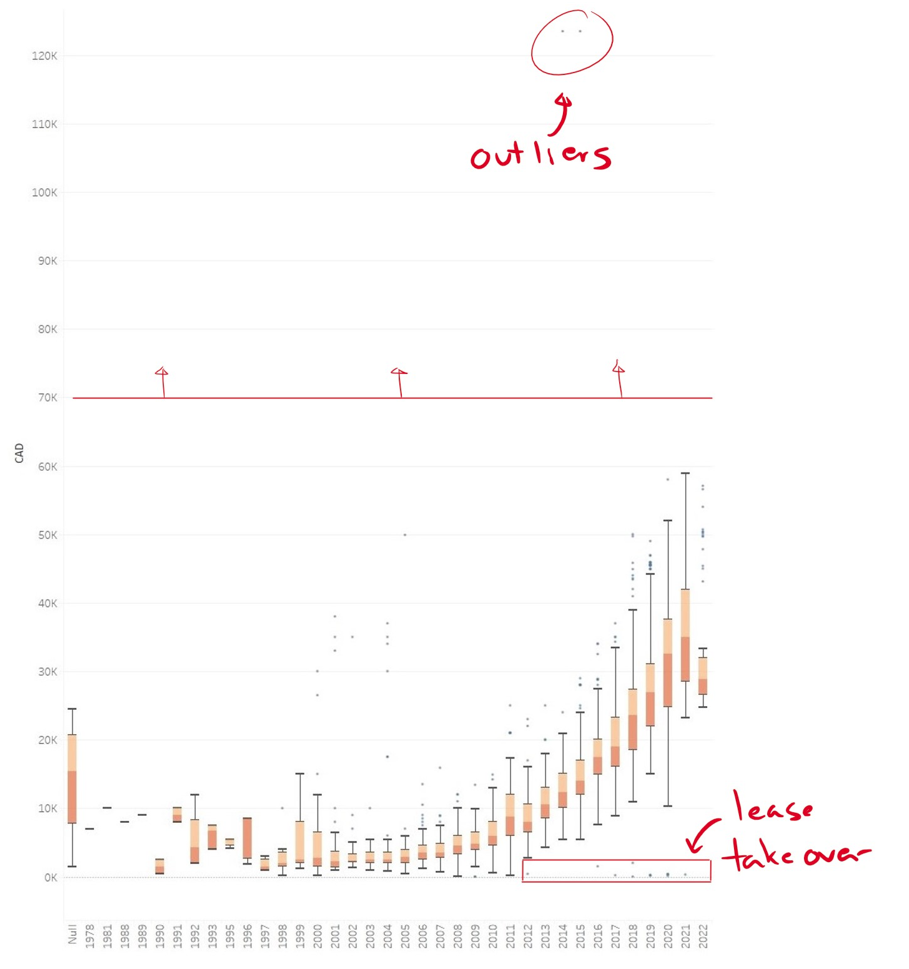

As per the data, it seems that some newer vehicles are sold for less than \$2,000. But upon further investigation, it came to light that our data includes 'lease takeovers', which show the price of monthly/weekly payments instead of the total cost of the vehicle.

We will be removing upper outliers and lease takeover in the data munging section.

### kilometres

Looking at the distribution of mileage across the year of manufacture, we can see what appears to be user errors. It seems like a significant amount of users added an extra zero to the mileage as it is unlikely to have so many functional 10-year-old vehicles with over 2 million kilometres. 

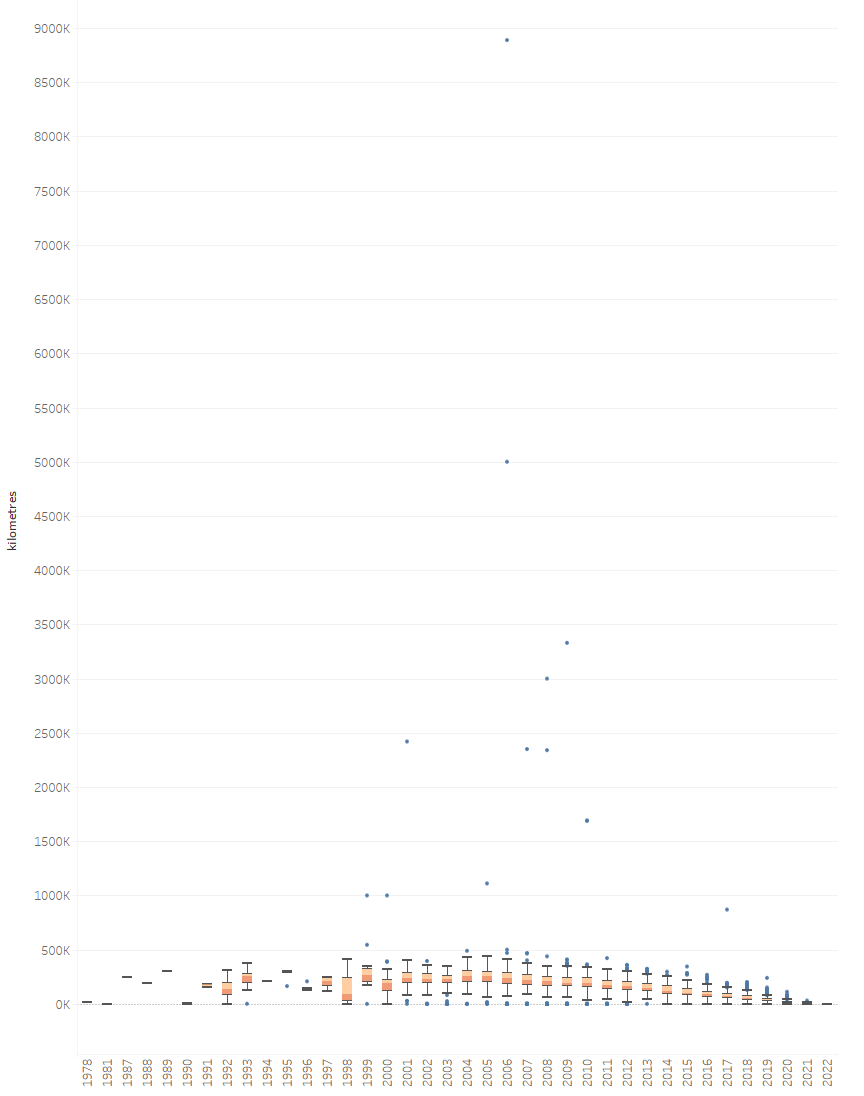

And looking at the lower outliers, we see that a significant number of users abbreviated the mileage to three digits. For example, a vehicle with 160,000 km is sometimes inserted with 160 km. From the context of the listing, it is obvious what the seller intended to communicate, but we will have to correct this before feeding the data to our model.

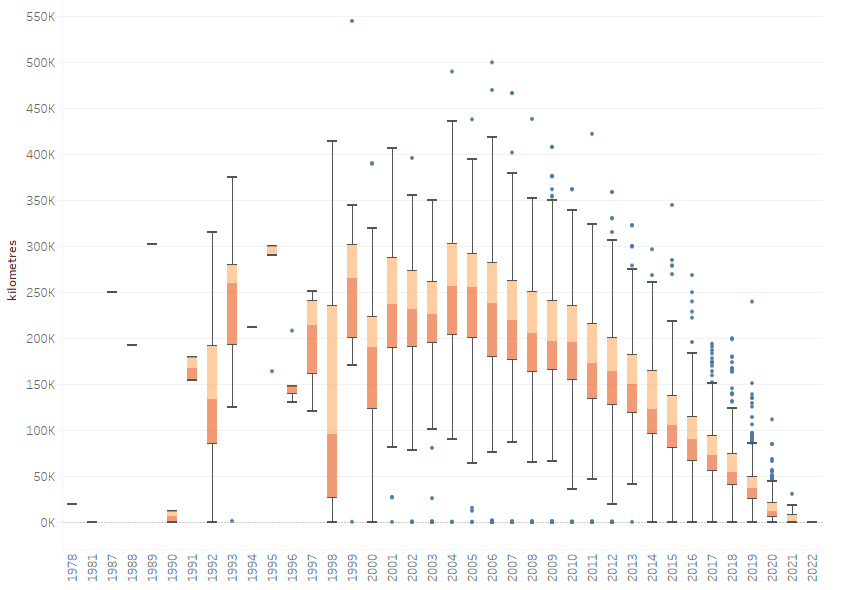

### model

The model of the vehicle is a critical indicator of its value. And looking at the distribution of models in our data, we observe immaculate features that will be one-hot encoded.

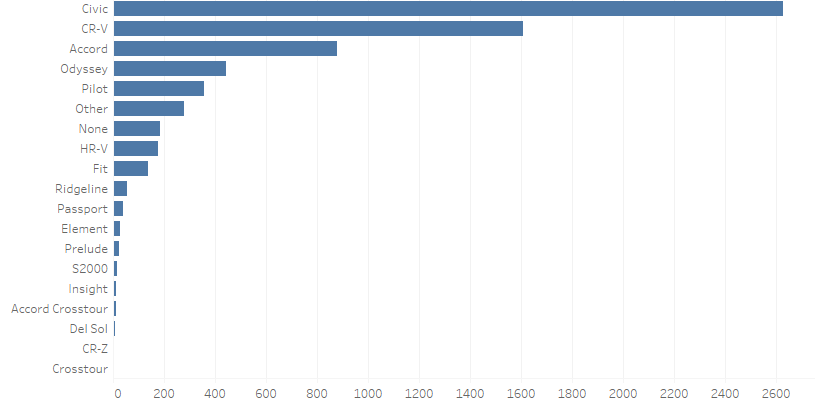

### drivetrain, transmission

The vehicle's transmission is a strong indicator of its value, and so is the drivetrain. However, we will not distinguish between front-wheel drive or rear-wheel drive for the drive train, nor between all-wheel drive or 4x4. Instead, we will have one one-hot encoded feature to flag a four-wheel drive vehicle (4x4 or AWD).

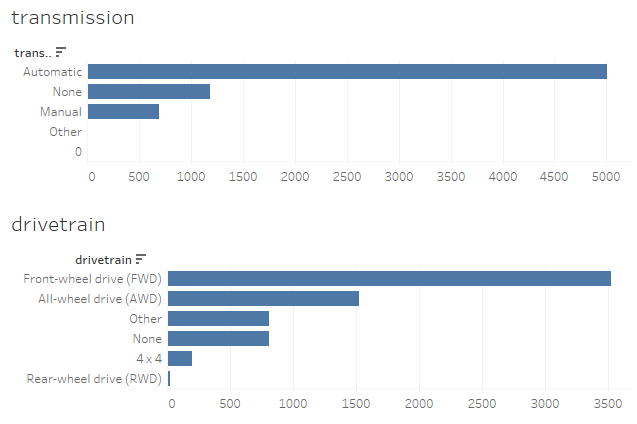

### colour, body type, fuel type

Finally, looking at the distribution of colour, body types and fuel types, we can see that the data appears usable. But those features are typically already encoded in the model of the vehicle. And although it would be interesting to see if the colour of the vehicle influences its cost, but this would be a separate project altogether. So we will not consider the colour, body type and fuel type in this model.

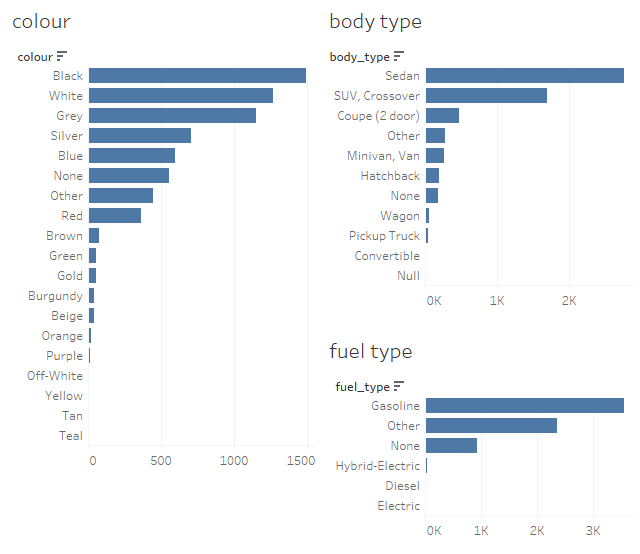

## Munging
After exploring the data, the best course of action is to convert the 'price', 'kilometres' and 'year' into integers and one-hot encode the rest. We will have to massage the price and kilometres as described in the data exploration phase.

In [ ]:
import json
import re


def get_price(row):
	"""
	Extract the price of a vehicle.
	Reject listings with no set price such as 'please call', 'free', 'swap/trade'.

	Vehicles from 2015 and up, sold for under $2000 are considered 'lease takeover'
	or 'salvage' and will be rejected.

	Vehicles sold for over $70000 are outliers and will be rejected as well.
	"""
	if re.search("^\$(\d{1,3},\d{3}|\d{1,3})(\.\d{2})?$", row['price']):
		# Allowed pattern: $(xxx,)xxx.xx | $(xxx,)xxx
		price = int(float(row['price'].replace('$', '').replace(',', '')))
		if get_year(row) >= 2015 and price <= 2000:
			raise AttributeError("price", "Rejected suspected lease-takeover listing.")
		elif price > 70000:
			raise AttributeError("price", "Rejected outlier.")
		else:
			return price
	raise AttributeError("price", "Invalid price field.")


def get_kilometers(row):
	"""
	Extract the mileage of a vehicle.

	I assume that vehicles with over two million kilometres are user input
	errors, and an extra zero was likely added, so this is correct.

	We assume that vehicles from 2015 and before with less than 1000 kilometres
	have had their mileage abbreviated.
	"""
	try:
		km = int(row['kilometres'].replace(',', ''))
		if km > 2_000_000:
			# suspected user input error - 3,500,000 km is likely 350,000 km
			return km/10
		elif km < 1_000 and get_year(row) <= 2015:
			# suspected abbreviated km - 200 km in a 2015 vehicle is likely 200_000 km
			return km * 1_000
		else:
			return km
	except ValueError:
		raise AttributeError("kilometres", "Invalid kilometres.")


def get_year(row):
	""" Year is a mandatory field and must be between 1978 and 2022 """
	try:
		year = int(row['year'])
		if 1978 <= year <= 2022:
			return year
	except ValueError:
		pass
	raise AttributeError("year", "Year is not between 1978 - 2022.")


def get_model(row):
	"""
	The vehicle's model is a mandatory field and for each row only one model
	can be set to 1. The remainder are all set to 0 by default.
	"""
	allowed_models = ['other', 'crosstour', 'fit', 'civic', 'ridgeline',
	                  'del sol', 'accord', 'passport', 'odyssey', 'insight',
	                  's2000', 'cr-z', 'accord crosstour', 'hr-v', 'element',
	                  'cr-v', 'prelude', 'pilot']
	if row['model'].lower() in allowed_models:
		return row['model'].lower()


def is_sport(row):
	""" Return 1 if the vehicle is confirmed to be a sports edition """
	keywords = ['si', 'sir', 'sr', 'sport', 'sports', 'vtec', 'turbo', '2.0t']
	for keyword in keywords:
		if re.search(f"( |-|\*|\||^){keyword}( |-|\.|\*|\||$)", row['trim'].lower()):
			# will match patterns where the keyword is surrounded by common
			# delimiters. eg: 'Si|sunroof|AWD' or '4dr-sedan-sports'
			return 1
	return 0


def is_leather(row):
	""" Has leather seats or not """
	fields = ['trim', 'description']
	for field in fields:
		if re.search("( |-|\*|\||^)leather( |-|\.|\*|\||$)", row[field].lower()):
			return 1
	return 0


def is_automatic(row):
	""" Has an automatic transmission. 1: automatic, 0: manual"""
	if row['transmission'].lower() == 'automatic':
		return 1
	elif row['transmission'].lower() == 'manual':
		return 0
	elif 'manual' in row['trim'].lower() or 'manual' in row['description'].lower():
		return 0
	return 1  # if not mentioned, assume automatic transmission


def is_awd(row):
	""" Has All-wheel-drive? AWD or 4x4: 1, FWD or RWD: 0"""
	TWD = ['front-wheel drive', 'rear-wheel drive', 'fwd', 'rwd']
	AWD = ['all-wheel drive', 'awd', '4x4', '4 x 4']
	search_sources = [row['drivetrain'].lower(), row['trim'].lower(), row['description'].lower()]
	for search_source in search_sources:
		for awd in AWD:
			if awd in search_source:
				return 1
		for twd in TWD:
			if twd in search_source:
				return 0
	return 0  # if not mentioned, assume two-wheel drive


if __name__ == '__main__':
	raw_field_names = ['link', 'price', 'make', 'model', 'year', 'kilometres',
	                  'body_type', 'drivetrain', 'transmission', 'fuel_type',
	                  'trim', 'colour', 'description']
	clean_field_names = ['price', 'kilometres', 'year',
	                    # models
	                    'other', 'crosstour', 'fit', 'civic', 'ridgeline',
	                    'del sol', 'accord', 'passport', 'odyssey', 'insight',
	                    's2000', 'cr-z', 'accord crosstour', 'hr-v', 'element',
	                    'cr-v', 'prelude', 'pilot',
	                    # other features
	                    'sport', 'leather', 'automatic', 'awd']
	rejected = set()
	accepted = []

	for row in raw_data:
		try:
			clean_row = {field: 0 for field in clean_field_names}
			clean_row['price'] = get_price(row)
			clean_row['kilometres'] = get_kilometers(row)
			clean_row['year'] = get_year(row)
			clean_row[get_model(row)] = 1
			clean_row['sport'] = is_sport(row)
			clean_row['leather'] = is_leather(row)
			clean_row['automatic'] = is_automatic(row)
			clean_row['awd'] = is_awd(row)
			accepted.append(clean_row)
		except AttributeError as err:
			rejected.add(f"Rejected field: '{err.args[0]}' with value: "
			             f"'{row[err.args[0]]}' (msg: '{err.args[1]}')")

	print('Output sample:\n',json.dumps(accepted[:5], indent=4),'\n')
	for rejected_row in sorted(rejected):
		print(rejected_row)

Output sample:
 [
    {
        "price": 57012,
        "kilometres": 7600,
        "year": 2021,
        "other": 0,
        "crosstour": 0,
        "fit": 0,
        "civic": 0,
        "ridgeline": 0,
        "del sol": 0,
        "accord": 0,
        "passport": 0,
        "odyssey": 0,
        "insight": 0,
        "s2000": 0,
        "cr-z": 0,
        "accord crosstour": 0,
        "hr-v": 0,
        "element": 0,
        "cr-v": 0,
        "prelude": 0,
        "pilot": 1,
        "sport": 0,
        "leather": 1,
        "automatic": 1,
        "awd": 1
    },
    {
        "price": 12500,
        "kilometres": 180000,
        "year": 2015,
        "other": 0,
        "crosstour": 0,
        "fit": 0,
        "civic": 0,
        "ridgeline": 0,
        "del sol": 0,
        "accord": 0,
        "passport": 0,
        "odyssey": 0,
        "insight": 0,
        "s2000": 0,
        "cr-z": 0,
        "accord crosstour": 0,
        "hr-v": 0,
        "element": 0,
        "cr-v":

All clean data: ( https://auto-appraiser.loudpumpkins.com/data/clean )

## Modeling

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


df = pd.read_json('https://auto-appraiser.loudpumpkins.com/data/clean')

# split data 80/20 for training and testing
train_features = df.sample(frac=0.8, random_state=0)
test_features = df.drop(train_features.index)

# remove the 'price' column as it is not part of given variables
train_labels = train_features.pop('price')
test_labels = test_features.pop('price')


def plot_loss(history, start=0, finish=10):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([start, finish])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.grid(True)

Before we start modelling, a final mention about the data is that we have some wildly different ranges of values for our variables. So we will be normalizing the data using Keras.

In [ ]:
df.describe().transpose()[['mean', 'min', 'max']][:7]

,mean,min,max
price,16495.284462,1.0,58871.0
kilometres,119900.345219,0.0,1690000.0
year,2013.820518,1978.0,2022.0
other,0.040239,0.0,1.0
crosstour,0.000199,0.0,1.0
fit,0.022112,0.0,1.0
civic,0.384064,0.0,1.0


In [ ]:
# normalized layer
norm = preprocessing.Normalization(input_shape=[24, ])
norm.adapt(np.array(train_features))

### Train using linear regression

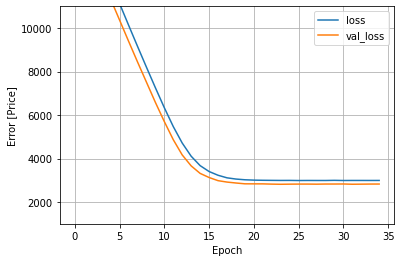


Final val_loss: 2828.658935546875


In [ ]:
# sequential model
linear_model = tf.keras.Sequential([
    norm,
    layers.Dense(units=1)
])

# configure training procedure
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=10),
    loss='mean_absolute_error'
)

# train
history = linear_model.fit(
    train_features, train_labels,
    epochs=35,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

# plot train
plot_loss(history, 1000, 11000)
plt.show()
print('\nFinal val_loss:', hist.at[34, 'val_loss'])

### Train using DNN

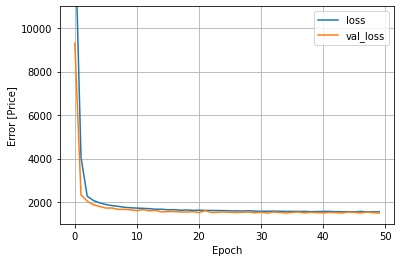


Final val_loss: 1496.332763671875


In [ ]:
# sequential model
dnn_model = tf.keras.Sequential([
    norm,
    layers.Dense(units=24*2, activation='relu'),
    layers.Dense(units=24*2, activation='relu'),
    layers.Dense(units=1)
])

# configure training procedure
dnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error'
)

# train
history = dnn_model.fit(
    train_features, train_labels,
    epochs=50,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

# plot train
plot_loss(history, 1000, 11000)
plt.show()
print('\nFinal val_loss:', hist.at[49, 'val_loss'])

## Conclusion

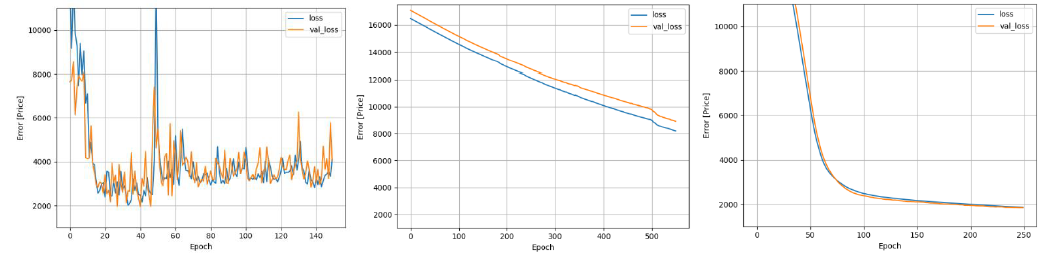

After experimenting with different hidden layers and units per layer, the DNN model outperformed the linear regression with a final cross-validation absolute mean loss of ~1500 against the linear regression's loss of ~2800.

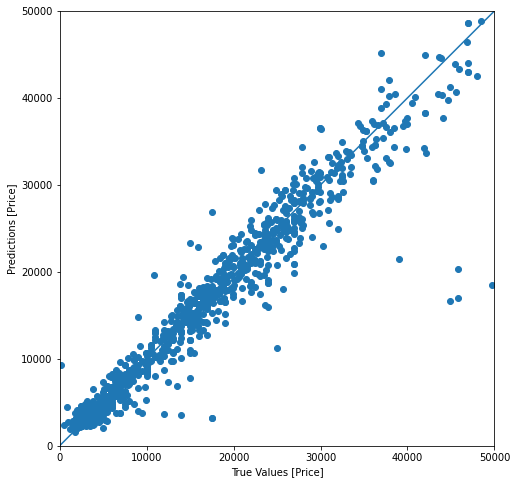

In [ ]:
# plot final result
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features['year'], test_labels, verbose=0)

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.rcParams["figure.figsize"] = 6, 6
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

So we will deploy the trained **DNN model**, which can be found here: **https://auto-appraiser.loudpumpkins.com**

## References

Browser puppeteer. https://github.com/loudpumpkins/selenium2  
Making predictions with keras. https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict  
Linear regression with TensorFlow. https://www.tensorflow.org/tutorials/keras/regression#linear_regression  
Fitting. https://www.tensorflow.org/tutorials/keras/overfit_and_underfit  